<a href="https://colab.research.google.com/github/owendaa/blogScripts/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [ ]:
#!pip install catboost

In [ ]:
#!pip install "cleanlab[all]"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score,fbeta_score, recall_score, precision_score, precision_recall_curve, average_precision_score, confusion_matrix
from datetime import datetime

from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
# https://catboost.ai/en/docs/concepts/python-reference_catboost

from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# check for data issues:
#https://docs.cleanlab.ai/stable/tutorials/datalab/tabular.html

from cleanlab.classification import CleanLearning
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv('/content/corona_tested_individuals_ver_006.english.csv', parse_dates=['test_date'], na_values=['None'])
# data = pd.read_csv('covidpred/data/corona_tested_individuals_ver_0083.english.csv')

# Understand the Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            278848 non-null  datetime64[ns]
 1   cough                278596 non-null  float64       
 2   fever                278596 non-null  float64       
 3   sore_throat          278847 non-null  float64       
 4   shortness_of_breath  278847 non-null  float64       
 5   head_ache            278847 non-null  float64       
 6   corona_result        278848 non-null  object        
 7   age_60_and_above     151528 non-null  object        
 8   gender               259285 non-null  object        
 9   test_indication      278848 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 21.3+ MB


In [ ]:
# number of cases and variables
df.shape

(278848, 10)

In [ ]:
df.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication'],
      dtype='object')

In [ ]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,negative,NaN,male,Other
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,male,Other


In [ ]:
# check for unique values and nan
for i in df.columns[1:]:
    print(f'{i}: ', df[i].unique())

cough:  [ 0.  1. nan]
fever:  [ 0.  1. nan]
sore_throat:  [ 0.  1. nan]
shortness_of_breath:  [ 0.  1. nan]
head_ache:  [ 0.  1. nan]
corona_result:  ['negative' 'positive' 'other']
age_60_and_above:  [nan 'Yes' 'No']
gender:  ['female' 'male' nan]
test_indication:  ['Other' 'Abroad' 'Contact with confirmed']


In [ ]:
# drop all rows where the target variable is not positive or negative
df = df[(df.corona_result == 'positive') | (df.corona_result == 'negative')]

In [ ]:
# values stats
for i in df.columns[1:]:
    print(f'{i}: \n', df[i].value_counts(dropna=False))

cough: 
 0.0    233133
1.0     41571
NaN       252
Name: cough, dtype: int64
fever: 
 0.0    253329
1.0     21375
NaN       252
Name: fever, dtype: int64
sore_throat: 
 0.0    273063
1.0      1892
NaN         1
Name: sore_throat, dtype: int64
shortness_of_breath: 
 0.0    273406
1.0      1549
NaN         1
Name: shortness_of_breath, dtype: int64
head_ache: 
 0.0    272572
1.0      2383
NaN         1
Name: head_ache, dtype: int64
corona_result: 
 negative    260227
positive     14729
Name: corona_result, dtype: int64
age_60_and_above: 
 NaN    125664
No     123867
Yes     25425
Name: age_60_and_above, dtype: int64
gender: 
 female    128541
male      127370
NaN        19045
Name: gender, dtype: int64
test_indication: 
 Other                     239404
Abroad                     25074
Contact with confirmed     10478
Name: test_indication, dtype: int64


In [ ]:
#Which symptoms have a reporting bias, i.e., likely to be reported when the patient is COVID positive?
df_g = pd.DataFrame(df.groupby('corona_result')['cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'age_60_and_above', 'gender',
       'test_indication'].value_counts(dropna=False).reset_index( name='count'))
df_g[df_g['corona_result']=='positive']

,corona_result,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,count
355,positive,0.0,0.0,0.0,0.0,0.0,No,male,Contact with confirmed,687
356,positive,0.0,0.0,0.0,0.0,0.0,No,female,Contact with confirmed,647
357,positive,0.0,0.0,0.0,0.0,0.0,No,male,Other,610
358,positive,0.0,0.0,0.0,0.0,0.0,NaN,male,Other,456
359,positive,0.0,0.0,0.0,0.0,0.0,NaN,female,Contact with confirmed,454
...,...,...,...,...,...,...,...,...,...,...
910,positive,1.0,0.0,0.0,1.0,1.0,NaN,female,Other,1
911,positive,1.0,0.0,0.0,1.0,1.0,Yes,female,Contact with confirmed,1
912,positive,1.0,0.0,0.0,1.0,1.0,No,NaN,Contact with confirmed,1
913,positive,1.0,0.0,0.0,1.0,1.0,No,NaN,Abroad,1


In [ ]:
# prepare the target variable
df.corona_result.value_counts( normalize=True)


negative    0.946431
positive    0.053569
Name: corona_result, dtype: float64

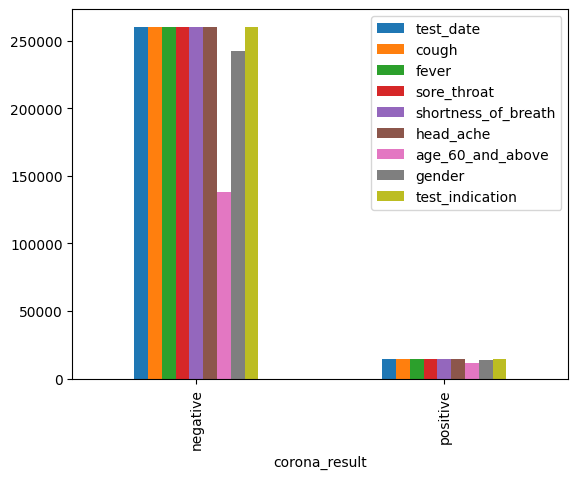

In [ ]:
# Visualisation: Draw the bar graph of features grouped by the target class 'corona_result'
# Group the data by the target class and count the occurrences of each feature
grouped_data = df.groupby('corona_result').count()

# Create a bar plot of the grouped data
grouped_data.plot(kind='bar')
plt.show()

In [ ]:
df.test_date

0        2020-04-30
1        2020-04-30
2        2020-04-30
3        2020-04-30
4        2020-04-30
            ...    
278842   2020-03-11
278843   2020-03-11
278844   2020-03-11
278845   2020-03-11
278847   2020-03-11
Name: test_date, Length: 274956, dtype: datetime64[ns]

In [ ]:
# drop test date column
#df.drop('test_date', axis=1, inplace=True)

In [ ]:
df

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,negative,NaN,male,Other
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,male,Other
...,...,...,...,...,...,...,...,...,...,...
278842,2020-03-11,0.0,0.0,0.0,0.0,0.0,negative,NaN,NaN,Other
278843,2020-03-11,0.0,0.0,0.0,0.0,0.0,negative,NaN,NaN,Other
278844,2020-03-11,0.0,0.0,0.0,0.0,0.0,negative,NaN,NaN,Other
278845,2020-03-11,0.0,0.0,0.0,0.0,0.0,positive,NaN,NaN,Contact with confirmed


# Processing

In [ ]:
# Dealing with missing data
df["gender"]=df["gender"].replace({np.NaN:2, 'male':1, 'female':0})
df["age_60_and_above"]=df["age_60_and_above"].replace({np.NaN:2, 'Yes':1, 'No':0})
df.dropna(subset=['cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'age_60_and_above', 'gender',
       'test_indication'], inplace=True)


In [ ]:
# orignial : (278848, 10)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274702 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            274702 non-null  datetime64[ns]
 1   cough                274702 non-null  float64       
 2   fever                274702 non-null  float64       
 3   sore_throat          274702 non-null  float64       
 4   shortness_of_breath  274702 non-null  float64       
 5   head_ache            274702 non-null  float64       
 6   corona_result        274702 non-null  object        
 7   age_60_and_above     274702 non-null  int64         
 8   gender               274702 non-null  int64         
 9   test_indication      274702 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 23.1+ MB


In [ ]:
df['corona_result'] = df['corona_result'].replace({'negative':0, 'positive':1})
df['test_indication'] = df['test_indication'].replace({'Other':0, 'Contact with confirmed':1, 'Abroad':2})
df

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,0,2,0,0
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,0,2,0,0
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,0,2,1,0
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,0,2,0,0
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
278842,2020-03-11,0.0,0.0,0.0,0.0,0.0,0,2,2,0
278843,2020-03-11,0.0,0.0,0.0,0.0,0.0,0,2,2,0
278844,2020-03-11,0.0,0.0,0.0,0.0,0.0,0,2,2,0
278845,2020-03-11,0.0,0.0,0.0,0.0,0.0,1,2,2,1


In [ ]:
df = df.astype('int')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274702 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   test_date            274702 non-null  int64
 1   cough                274702 non-null  int64
 2   fever                274702 non-null  int64
 3   sore_throat          274702 non-null  int64
 4   shortness_of_breath  274702 non-null  int64
 5   head_ache            274702 non-null  int64
 6   corona_result        274702 non-null  int64
 7   age_60_and_above     274702 non-null  int64
 8   gender               274702 non-null  int64
 9   test_indication      274702 non-null  int64
dtypes: int64(10)
memory usage: 23.1 MB


In [ ]:

df["test_date"] = pd.to_datetime(df["test_date"])
df["test_date"] = df["test_date"].dt.dayofweek


In [ ]:
df['test_date'].unique()

array([3, 2, 1, 0, 6, 5, 4])

In [ ]:
# Next action: data split, imbalance data, basline model

In [ ]:

X = df.drop(columns = 'corona_result', axis=1)
y = df['corona_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

In [ ]:

clf = LogisticRegression()
label_issues_info = CleanLearning(clf=clf).find_label_issues(X, y)
label_issues_info

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.982730,0,0
1,False,0.978927,0,0
2,False,0.936921,0,0
3,False,0.978927,0,0
4,False,0.977930,0,0
...,...,...,...,...
274697,False,0.982364,0,0
274698,False,0.981661,0,0
274699,False,0.981838,0,0
274700,True,0.030004,1,0


In [ ]:
label_issues_info[label_issues_info['is_label_issue']==False]

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.982730,0,0
1,False,0.978927,0,0
2,False,0.936921,0,0
3,False,0.978927,0,0
4,False,0.977930,0,0
...,...,...,...,...
274696,False,0.981661,0,0
274697,False,0.982364,0,0
274698,False,0.981661,0,0
274699,False,0.981838,0,0


# Base  Model

In [ ]:



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the dummy classifier using the 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy='stratified')

# Train the dummy classifier on the training data
dummy_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy_clf.predict(X_test)


## Evaluation

In [ ]:
y_probs = dummy_clf.predict_proba(X_test)[:, 1].flatten()
# Convert probabilities to class labels
y_pred = (y_probs > 0.22).astype(int)
print(classification_report(y_test, y_pred))

AUC-ROC: 0.498454860855194


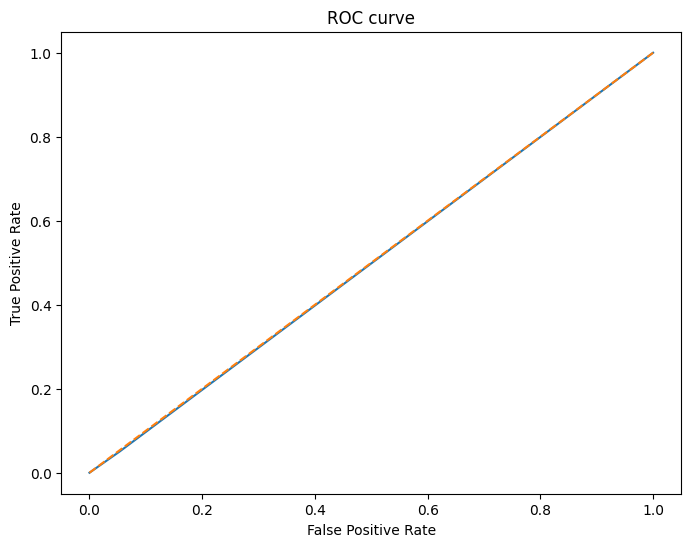

In [ ]:

# Predict probabilities for the test data.
y_probs = dummy_clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Print the AUC-ROC score
print('AUC-ROC:', roc_auc_score(y_test, y_probs))

Average precision score: 0.05222028170226325


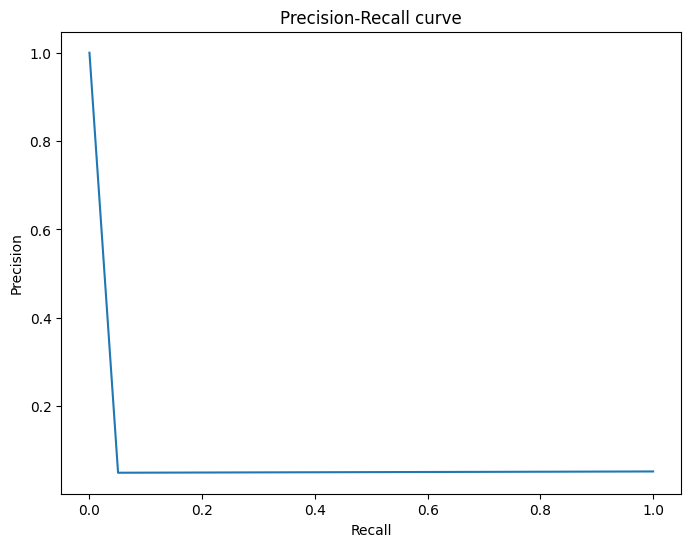

In [ ]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Print the average precision score
print('Average precision score:', average_precision_score(y_test, y_probs))

<Axes: >

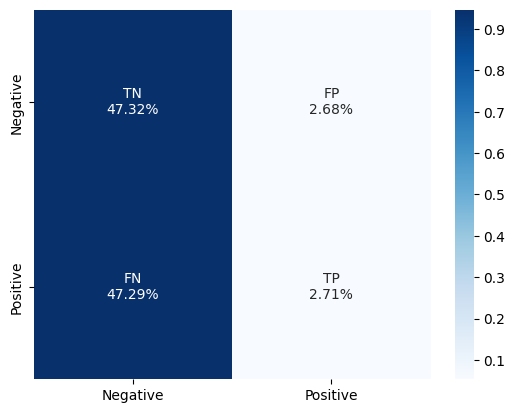

In [ ]:
# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
group_names = ['TN','FP','FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2, in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])


# CatBoost Modelling

In [ ]:
# List of categorical columns
cat_cols = ['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']

# List of numeric columns
num_cols = []

cat_features = [int(X_train.columns.get_loc(col)) for col in cat_cols]

In [ ]:

# Custom converter function
def convert_to_string(value):
    try:
        value = float(value)
        if np.isnan(value):
            return 'NaN'
        return str(int(value)) if value.is_integer() else str(value)
    except ValueError:
        return str(value)

# Preprocessing pipeline
preprocess = ColumnTransformer([
                                ('imputer_cat', SimpleImputer(add_indicator=True, strategy='most_frequent'), cat_cols),
                                ('converter', FunctionTransformer(func=lambda x: x.applymap(convert_to_string)), cat_cols ),
                                ('imputer_num', SimpleImputer(add_indicator=True,strategy='mean'), num_cols),

                                ], remainder='passthrough')




In [ ]:
# CatBoost model with cost-sensitive learning
catboost_model = CatBoostClassifier(
    cat_features=cat_features,
    loss_function='Logloss',
    auto_class_weights='Balanced',
    verbose=1
)

# Create the pipeline
model = Pipeline([
              ('preprocess', preprocess),
              ('catboost', catboost_model)
                ])

In [ ]:

param_grid = {
    'catboost__iterations': [100],
    'catboost__grow_policy': ['SymmetricTree'],
    'catboost__learning_rate': [0.5],
    'catboost__depth': [8],
    'catboost__l2_leaf_reg': [2],
}

# Perform randomized grid search
search = GridSearchCV(model, param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv=3)
search.fit(X_train, y_train)

# Get the best model and its performance
print(f' Best model: { search.best_estimator_}')
print(f'Best_score:  {search.best_score_}')
print(f'Best_params: {search.best_params_}')
best_model = search.best_estimator_


Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.4800115	total: 189ms	remaining: 18.7s
1:	learn: 0.4073132	total: 293ms	remaining: 14.3s
2:	learn: 0.3761422	total: 401ms	remaining: 13s
3:	learn: 0.3593503	total: 527ms	remaining: 12.6s
4:	learn: 0.3514965	total: 651ms	remaining: 12.4s
5:	learn: 0.3474942	total: 757ms	remaining: 11.9s
6:	learn: 0.3458138	total: 838ms	remaining: 11.1s
7:	learn: 0.3443346	total: 937ms	remaining: 10.8s
8:	learn: 0.3441004	total: 990ms	remaining: 10s
9:	learn: 0.3438349	total: 1.04s	remaining: 9.37s
10:	learn: 0.3436970	total: 1.11s	remaining: 8.99s
11:	learn: 0.3415374	total: 1.22s	remaining: 8.98s
12:	learn: 0.3408362	total: 1.34s	remaining: 8.96s
13:	learn: 0.3407946	total: 1.39s	remaining: 8.56s
14:	learn: 0.3405665	total: 1.5s	remaining: 8.47s
15:	learn: 0.3405578	total: 1.55s	remaining: 8.12s
16:	learn: 0.3400310	total: 1.67s	remaining: 8.16s
17:	learn: 0.3400176	total: 1.72s	remaining: 7.84s
18:	learn: 0.3390911	total: 1.82s	rema

In [ ]:
# Fit the best model to the training data
best_model.fit(X_train, y_train)

0:	learn: 0.4800115	total: 136ms	remaining: 13.5s
1:	learn: 0.4073132	total: 240ms	remaining: 11.8s
2:	learn: 0.3761422	total: 349ms	remaining: 11.3s
3:	learn: 0.3593503	total: 468ms	remaining: 11.2s
4:	learn: 0.3514965	total: 583ms	remaining: 11.1s
5:	learn: 0.3474942	total: 699ms	remaining: 11s
6:	learn: 0.3458138	total: 780ms	remaining: 10.4s
7:	learn: 0.3443346	total: 888ms	remaining: 10.2s
8:	learn: 0.3441004	total: 944ms	remaining: 9.54s
9:	learn: 0.3438349	total: 998ms	remaining: 8.98s
10:	learn: 0.3436970	total: 1.07s	remaining: 8.65s
11:	learn: 0.3415374	total: 1.18s	remaining: 8.67s
12:	learn: 0.3408362	total: 1.29s	remaining: 8.62s
13:	learn: 0.3407946	total: 1.34s	remaining: 8.25s
14:	learn: 0.3405665	total: 1.44s	remaining: 8.18s
15:	learn: 0.3405578	total: 1.5s	remaining: 7.88s
16:	learn: 0.3400310	total: 1.62s	remaining: 7.9s
17:	learn: 0.3400176	total: 1.67s	remaining: 7.62s
18:	learn: 0.3390911	total: 1.77s	remaining: 7.57s
19:	learn: 0.3390779	total: 1.83s	remaining: 

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_cat',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent'),
                                                  ['test_date', 'cough',
                                                   'fever', 'sore_throat',
                                                   'shortness_of_breath',
                                                   'head_ache',
                                                   'age_60_and_above', 'gender',
                                                   'test_indication']),
                                                 ('converter',
                                                  FunctionTransformer(func=<function <lambda> at 0x7bfe4567f910>),
                                                  ['test_date', 'cough',
                                                   'fever', 'sore_throat',
                                                   'shortness_of_breath',
                                                   'head_ache',
                                                   'age_60_and_above', 'gender',
                                                   'test_indication']),
                                                 ('imputer_num',
                                                  SimpleImputer(add_indicator=True),
                                                  [])])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7bfe456aabc0>)])

## Evaluation

AUC-ROC: 0.9090614844989584


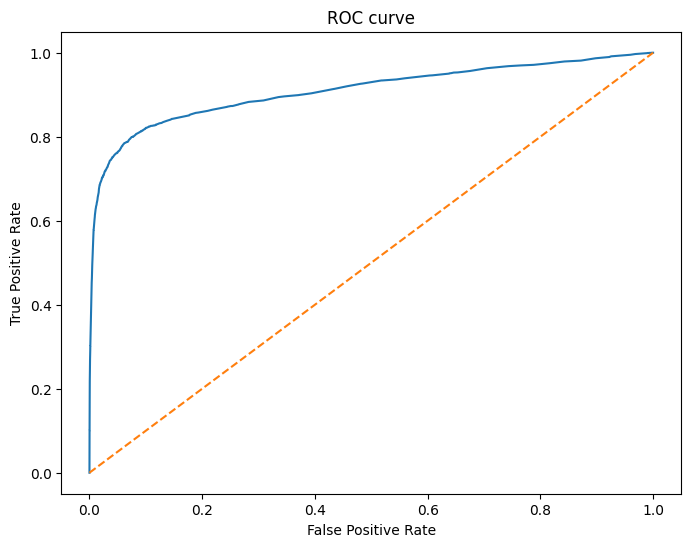

In [ ]:
# Predict probabilities for the test data.
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Print the AUC-ROC score
print('AUC-ROC:', roc_auc_score(y_test, y_probs))

Average precision score: 0.697145743909652


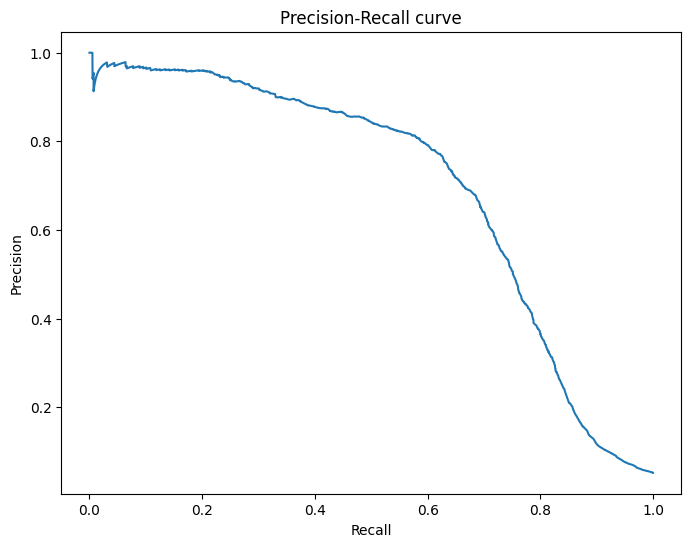

In [ ]:

# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Print the average precision score
print('Average precision score:', average_precision_score(y_test, y_probs))

In [ ]:

y_probs = best_model.predict_proba(X_test)[:, 1].flatten()
# Convert probabilities to class labels
y_pred = (y_probs > 0.22).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     52064
           1       0.16      0.87      0.28      2877

    accuracy                           0.76     54941
   macro avg       0.58      0.81      0.57     54941
weighted avg       0.95      0.76      0.83     54941



<Axes: >

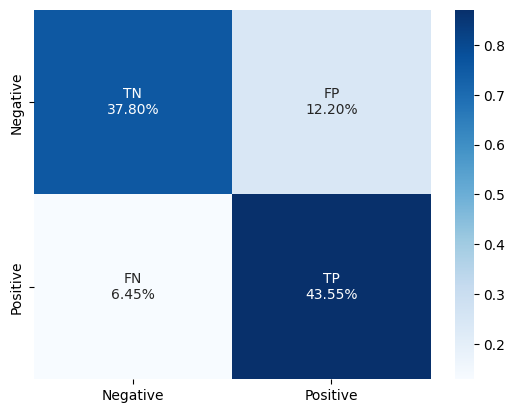

In [ ]:
# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
group_names = ['TN','FP','FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2, in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

In [ ]:
# choosing the threshold
# Define the threshold values to search
threshold_values = np.linspace(0.05, 0.8, 20)  # For example, search from 0.1 to 0.9 with 0.1 step

# Initialize variables to store the best recall and corresponding threshold
best_recall = 0.0
best_recall_threshold = None

# Find the threshold that maximizes recall
for threshold in threshold_values:
    y_pred = (y_probs >= threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)


    print(f"Threshold: {threshold:.2f}\t\tRecall: {recall:.3f} \t\tprecision: {precision:.3f}")

    if recall > best_recall:
        best_recall = recall
        best_recall_threshold = threshold

print(f"\nBest Recall Threshold: {best_recall_threshold:.2f}")

Threshold: 0.05		Recall: 1.000 		precision: 0.053
Threshold: 0.09		Recall: 0.995 		precision: 0.054
Threshold: 0.13		Recall: 0.946 		precision: 0.079
Threshold: 0.17		Recall: 0.913 		precision: 0.105
Threshold: 0.21		Recall: 0.874 		precision: 0.158
Threshold: 0.25		Recall: 0.854 		precision: 0.205
Threshold: 0.29		Recall: 0.838 		precision: 0.252
Threshold: 0.33		Recall: 0.833 		precision: 0.265
Threshold: 0.37		Recall: 0.827 		precision: 0.285
Threshold: 0.41		Recall: 0.821 		precision: 0.310
Threshold: 0.44		Recall: 0.812 		precision: 0.329
Threshold: 0.48		Recall: 0.800 		precision: 0.364
Threshold: 0.52		Recall: 0.788 		precision: 0.395
Threshold: 0.56		Recall: 0.778 		precision: 0.427
Threshold: 0.60		Recall: 0.769 		precision: 0.440
Threshold: 0.64		Recall: 0.753 		precision: 0.495
Threshold: 0.68		Recall: 0.744 		precision: 0.526
Threshold: 0.72		Recall: 0.734 		precision: 0.546
Threshold: 0.76		Recall: 0.719 		precision: 0.585
Threshold: 0.80		Recall: 0.706 		precision: 0.620


In [ ]:
# the threshold

# Get the probability threshold
probability_threshold = best_model.named_steps['catboost'].get_probability_threshold()
print(probability_threshold)
# Change the probability threshold to a new value (e.g., 0.6)
# new_threshold = 0.6
# best_model.named_steps['catboost'].set_probability_threshold(new_threshold)

0.5


# Random Forest

In [ ]:
# random forest

from sklearn.ensemble import RandomForestClassifier

# rf model
rf_model = RandomForestClassifier(
    n_estimators = 200,
    criterion = "entropy",
    max_features = "sqrt",
    class_weight="balanced_subsample",
)

In [ ]:
# Perform randomized grid search

param_grid_rf = {
    'rf__max_depth': [10],
    'rf__min_samples_leaf': [10],
}
model_rf = Pipeline([
              ('preprocess', preprocess),
              ('rf', rf_model)
                ])

search_rf = GridSearchCV(model_rf, param_grid_rf, scoring='roc_auc', verbose=0, n_jobs=-1, cv=2)
search_rf.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer_cat',
                                                                         SimpleImputer(add_indicator=True,
                                                                                       strategy='most_frequent'),
                                                                         ['test_date',
                                                                          'cough',
                                                                          'fever',
                                                                          'sore_throat',
                                                                          'shortness_of_breath',
                                                                          'head_ache',
                                                                          'age_60_and_above',
                                                                          'gender',
                                                                          'test_indication']),
                                                                        ('converter',
                                                                         FunctionTransformer(func...
                                                                          'fever',
                                                                          'sore_throat',
                                                                          'shortness_of_breath',
                                                                          'head_ache',
                                                                          'age_60_and_above',
                                                                          'gender',
                                                                          'test_indication']),
                                                                        ('imputer_num',
                                                                         SimpleImputer(add_indicator=True),
                                                                         [])])),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced_subsample',
                                                               criterion='entropy',
                                                               n_estimators=200))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10], 'rf__min_samples_leaf': [10]},
             scoring='roc_auc')

In [ ]:
# Get the best model and its performance
print(f' Best model: { search_rf.best_estimator_}')
print(f'Best_score:  {search_rf.best_score_}')
print(f'Best_params: {search_rf.best_params_}')


 Best model: Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_cat',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent'),
                                                  ['test_date', 'cough',
                                                   'fever', 'sore_throat',
                                                   'shortness_of_breath',
                                                   'head_ache',
                                                   'age_60_and_above', 'gender',
                                                   'test_indication']),
                                                 ('converter',
                                                  FunctionTransformer(func=<function <lambda> at 0x7bfe4567f910>),
                                       

In [ ]:
best_model_rf = search_rf.best_estimator_

In [ ]:
best_model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_cat',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent'),
                                                  ['test_date', 'cough',
                                                   'fever', 'sore_throat',
                                                   'shortness_of_breath',
                                                   'head_ache',
                                                   'age_60_and_above', 'gender',
                                                   'test_indication']),
                                                 ('converter',
                                                  FunctionTransformer(func=<function <lambda> at 0x7bfe4567f910>),
                                                  ['test_date', 'cough',
                                                   'fever', 'sore_throat',
                                                   'shortness_of_breath',
                                                   'head_ache',
                                                   'age_60_and_above', 'gender',
                                                   'test_indication']),
                                                 ('imputer_num',
                                                  SimpleImputer(add_indicator=True),
                                                  [])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=10,
                                        min_samples_leaf=10,
                                        n_estimators=200))])

In [ ]:
y_pred = best_model_rf.predict_proba(X_test).flatten()

In [ ]:
y_pred

array([0.76198235, 0.23801765, 0.84257144, ..., 0.11218582, 0.87154946,
       0.12845054])

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

y_probs = best_model.predict_proba(X_test)[:, 1].flatten()
# Convert probabilities to class labels
y_pred = (y_probs > 0.22).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     52064
           1       0.16      0.87      0.28      2877

    accuracy                           0.76     54941
   macro avg       0.58      0.81      0.57     54941
weighted avg       0.95      0.76      0.83     54941



AUC-ROC: 0.9081597708464585


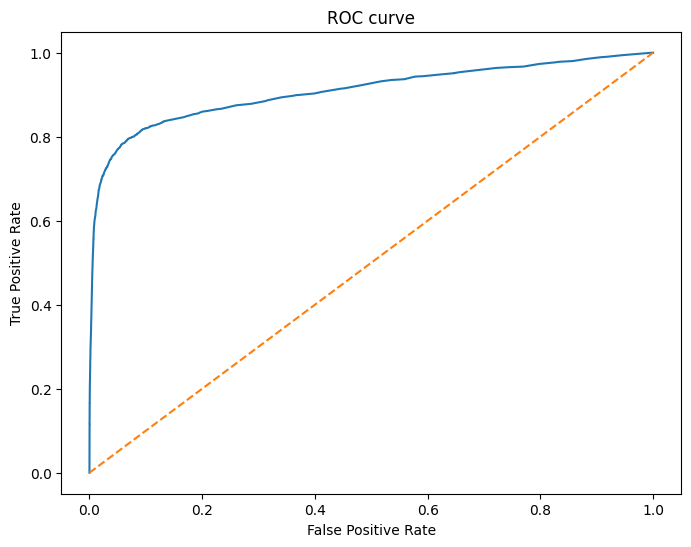

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the test data.
y_probs = best_model_rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Print the AUC-ROC score
print('AUC-ROC:', roc_auc_score(y_test, y_probs))

Average precision score: 0.6895607066291722


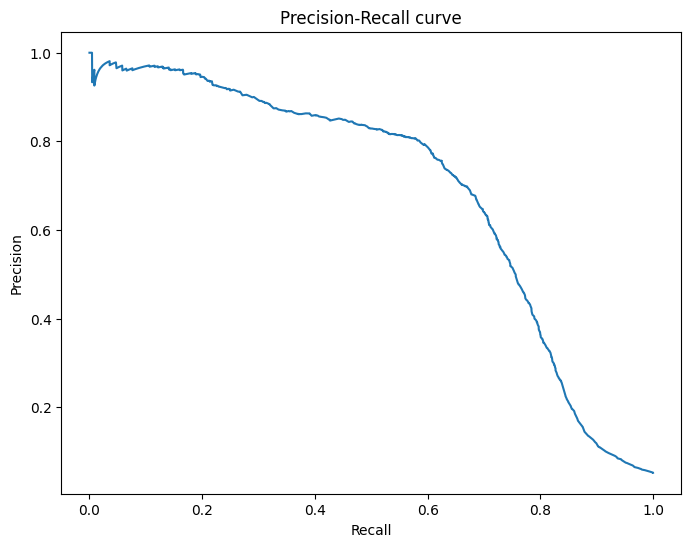

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Print the average precision score
print('Average precision score:', average_precision_score(y_test, y_probs))

In [ ]:
from sklearn.metrics import fbeta_score, recall_score, precision_score

In [ ]:
y_probs = best_model_rf.predict_proba(X_test)[:, 1]

In [ ]:
threshold = 0.2 # lowering the threshold, increases the recall
y_pred = (y_probs >= threshold).astype(int)

In [ ]:
f2 = fbeta_score(y_test, y_pred, beta=2)
f2

0.47689188155176376

In [ ]:
recall_score(y_test, y_pred)

0.8665276329509907

In [ ]:
precision_score(y_test, y_pred)

0.17040328092959672

<Axes: >

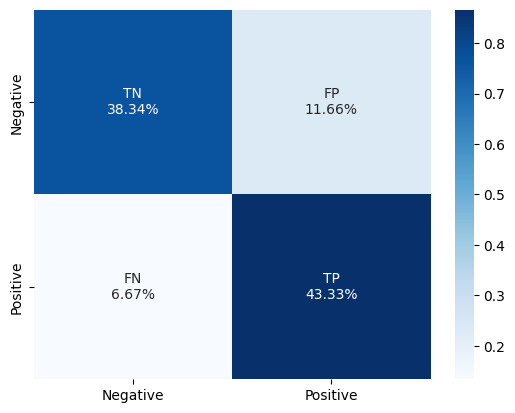

In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
group_names = ['TN','FP','FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2, in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Stacking Model

In [ ]:

# Create the base classifiers
mlp_clf = MLPClassifier(hidden_layer_sizes=(32, 50), activation='relu', solver='adam', alpha=0.01, max_iter=100, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
gnb_clf = GaussianNB()
svc_clf = SVC(probability=True, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=3)

# Create the meta-classifier (final estimator)
logistic_clf = LogisticRegression(max_iter=300, random_state=42)

# Create the stacking classifier
ensemble_model = StackingClassifier(
    estimators=[
        ('mlp', mlp_clf),
        ('decision_tree', dt_clf),
        ('gnb', gnb_clf),
        ('svc', svc_clf),
        ('knn', knn_clf)
    ],
    final_estimator=logistic_clf
)

# Train the stacking classifier on the training data
ensemble_model.fit(X_train, y_train)





## Evaluation

In [ ]:
y_probs = ensemble_model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.2).astype(int)
print(classification_report(y_test, y_pred))

In [ ]:
# Predict probabilities for the test data.
y_probs = ensemble_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Print the AUC-ROC score
print('AUC-ROC:', roc_auc_score(y_test, y_probs))

In [ ]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Print the average precision score
print('Average precision score:', average_precision_score(y_test, y_probs))

In [ ]:
# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
group_names = ['TN','FP','FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2, in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])